In [107]:
#math
import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [108]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(1000,)
(1000, 2)
ModeResult(mode=array([0.]), count=array([75]))


In [109]:
np.random.seed()
yn,xn,nobs = gen_data()

In [110]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,cc=False,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self._set_extra_params_names(['var'])
        self.start_params = np.array([1]*(self.exog.shape[1]+1))
        self.cc = cc
        self.ols = ols
        #self.start_params = np.array( range(1, (2*self.exog.shape[1]+2)))
        #2 sets of params for z, 1 for x, 2 variances...
    
    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        
       
        #if complete case, assign pr missing to all observations...
        pr_m = np.log(max(m.mean(),1e-4))
        if not self.cc:
            pr_m = stats.norm.logcdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        
        #we're done if ols
        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll
        
    def score(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        m_x = np.repeat(m,x.shape[1]).reshape(x.shape)
        
        if ols: #if OLS use all the data...
            m, m_x = np.ones(y.shape), np.ones(x.shape)
        
        
        b = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        s =  np.sqrt(sigma2)

        beta_jac = np.zeros(len(b))
        sigma_jac = 0
        
        #for censored
        if not cc and not ols: 
            left_stats = (y - np.dot(x, b)) / s
            l_pdf = scipy.stats.norm.logpdf(left_stats)
            l_cdf = scipy.stats.norm.logcdf(left_stats)
            left_frac = np.exp(l_pdf - l_cdf)
            beta_left = np.dot(left_frac*m, x*m_x / s)
            beta_jac -= beta_left
            left_sigma = np.dot(left_frac*m, left_stats*m)
            sigma_jac -= left_sigma
        
        #for non-censored
        mid_stats = (y - np.dot(x, b)) / s
        beta_mid = np.dot(mid_stats*(1-m), x*(1-m_x) / s)
        beta_jac += beta_mid
        mid_sigma = ((np.square(mid_stats) - 1)*(1-m)).sum()
        sigma_jac += mid_sigma
        
        combo_jac = np.append(beta_jac, sigma_jac / (2*s) )  # by chain rule, since the expression above is dloglik/dlogsigma
        return combo_jac


model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Tobit Results                                 
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -1355.7
Model:                          Tobit   AIC:                             2715.
Method:            Maximum Likelihood   BIC:                             2725.
Date:                Mon, 07 Dec 2020                                         
Time:                        16:26:32                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9437      0.049     19.430      0.000       0.848       1.039
x1             0.2651      0.007     38.813      0.000       0.252       0.278
var            0.9791      0.046     21.156      0.000       0.888       1.070
==============================================================================
"""

In [111]:
model3 = sm.OLS(yn,sm.add_constant(xn))
model3_fit = model3.fit()
print(model3_fit.summary())

model3 =  Tobit(yn,sm.add_constant(xn),ols=True)
model3_fit = model3.fit(disp=False)
print(model3_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     1574.
Date:                Mon, 07 Dec 2020   Prob (F-statistic):          2.42e-207
Time:                        16:26:32   Log-Likelihood:                -1355.4
No. Observations:                1000   AIC:                             2715.
Df Residuals:                     998   BIC:                             2725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1382      0.043     26.645      0.0

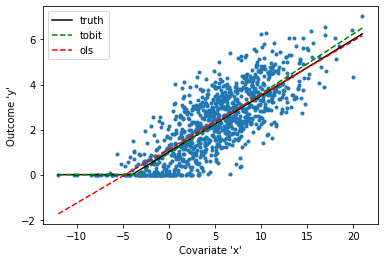

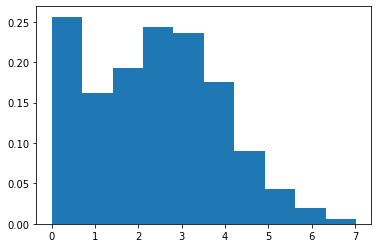

In [113]:
#create plot for true
plt.scatter(xn,yn,marker='.')
support_x = np.arange(xn.min(),xn.max(),.05)

#truth
plt.plot(support_x, np.maximum(beta0+beta1*support_x,0) ,label="truth",
         color='black')

#tobit
plt.plot(support_x, np.maximum(0,model1_fit.params[0] + model1_fit.params[1]*support_x) ,label="tobit",
         color='green',linestyle='--')

#ols
plt.plot(support_x, model3_fit.params[0] + model3_fit.params[1]*support_x ,label="ols",
         color='red',linestyle='--')



#create plot for normal
plt.ylabel("Outcome 'y'")
plt.xlabel("Covariate 'x'")
plt.savefig('../figs/tobit_plot1.png')
plt.legend()
plt.show()

plt.hist(yn,density=True)
plt.show()

In [114]:
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).sum() )
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).var() )
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).max() )
print( (model1.loglikeobs(model1_fit.params)- model3.loglikeobs(model3_fit.params)).min() )

-0.39003144492788566
0.039413324031911515
2.5684803434564096
-0.45732526270321694


In [115]:
y_cens, x_cens = yn[yn!=0],xn[yn!=0]
model2 = sm.OLS(y_cens,sm.add_constant(x_cens))
model2_fit = model2.fit()
print(model2_fit.summary())

model2 =  Tobit(yn,sm.add_constant(xn),cc=True)
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

print(np.log(yn[yn==0].shape[0]/1000)*yn[yn==0].shape[0] )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     1069.
Date:                Mon, 07 Dec 2020   Prob (F-statistic):          9.78e-156
Time:                        16:27:25   Log-Likelihood:                -1235.6
No. Observations:                 913   AIC:                             2475.
Df Residuals:                     911   BIC:                             2485.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2440      0.051     24.242      0.0

In [116]:
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).sum() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).var() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).max() )
print( (model1.loglikeobs(model1_fit.params)- model2.loglikeobs(model2_fit.params)).min() )

92.25641047193231
0.21491574493852755
2.429940716035291
-0.9781412652300245
